This script allows to investigate important variables that determine foehn strength at a given location. It is structured the following:
1. Read and preprocess data
1. Fit an XGBoost model to the train set
1. Evaluate performance on test set and compare to content from Gerstgrasser (2017)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load packages
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import *
from sklearn.metrics import *
from sklearn.inspection import * 
from utils import *
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pearsonr
import seaborn as sns

# Import constants from constants.py file in directory above
import sys
sys.path.append("..")
from constants import *

# Define plotting style
sns.set_style("whitegrid")
sns.set_palette("deep")
#plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

--- Avaliable variables ---
Base directory: BASE_DIR
Month names: MONTH_NAMES
Bounding box coordinates: LON_MIN, LON_MAX, LAT_MIN, LAT_MAX
ERAI coordinates: LONS_ERA, LATS_ERA
CESM coordinates: LONS_CESM, LATS_CESM
CESM slice: INDEX_CESM
CESM coordinates for plotting (string): LONS_CESM_STRING, LATS_CESM_STRING


# Define functions

In [3]:
def calculate_horizontal_feature_differences(df, variable):
    """
    Calculate the horizontal differences for a given variable between all stations.
    @param df: Dataframe with all measurement values for all stations
    @param variable: String with variable of interest
    """
    
    df_variable = df.filter(regex=(f"{variable}"))
    
    feature_dict = {}

    variable_list1 = sorted(df_variable.columns.tolist())
    variable_list2 = sorted(df_variable.columns.tolist())

    for col1 in variable_list1:
        variable_list2.remove(col1)
        for col2 in variable_list2:
            feature_dict[f"diff_{col1}_{col2}"] = (df_variable.loc[:, col1] - df_variable.loc[:, col2]).values

    return pd.DataFrame(feature_dict)

def evaluate_regression(y_true, y_pred):
    """
    Automatically evaluate the performance of a regressor (model-agnostic)
    @param y_true: True labels
    @param y_pred: Predicted labels
    """
    
    # Calculate maximum range
    min_val, max_val = min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))

    # Prediction density plot
    plt.figure()
    sns.distplot(y_true, kde=True, bins=np.linspace(min_val, max_val, 20))
    sns.distplot(y_pred, kde=True, bins=np.linspace(min_val, max_val, 20), color="orange")
    plt.legend(["True", "Pred"])
    plt.title("Prediction histogram")

    # Scatter plot
    plt.figure()
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([min_val, max_val], [min_val, max_val], "r-")
    plt.axis('square')
    plt.xlabel("True label")
    plt.ylabel("Pred label")

    # Print regression metrics
    print('(MAE) Mean absolute error: ', round(mean_absolute_error(y_true, y_pred), 4))
    #print('(MSE) Mean squared error: ', round(mean_squared_error(y_true, y_pred), 4))
    print('(RMSE) Root mean squared error: ', round(np.sqrt(mean_squared_error(y_true, y_pred)),4))  # Gives a relatively high weight to large errors (compared to MAE)
    #print('(RMSLE) Root mean squared log error: ', round(mean_squared_log_error(y_true, y_pred),4))  # Punishes underprediction harder, robuster towards outliers, also considers a relative error
    #print('(MAPE) Mean absolute percentage error: ', round(mean_absolute_percentage_error(y_true, y_pred), 4))  # sensitive to relative errors, scale-invariant
    #print('(MedAE) Median absolute error: ', round(median_absolute_error(y_true, y_pred), 4))  # Robust to outliers
    print('(R2) R2-score: ', round(r2_score(y_true, y_pred), 4))
    #print('(EV) Explained_variance: ', round(explained_variance_score(y_true, y_pred), 4))  # Equivalent to R2 if mean error/residuals == 0, otherwise bias in residuals
    print('(CorrCoeff) Correlation Coefficient: ', round(pearsonr(y_true, y_pred)[0], 4)) 

# Read data

In [4]:
# Load foehn measurement data for all stations from another project
df_foehn = pd.read_csv(os.path.join(os.path.dirname(BASE_DIR), "foehn-fire-impact", "data", "03_primary", "foehn_data_prepared.csv"))

# Target specification and preprocessing

In [5]:
# Specify target variable
location = "ALT"
target_var = "FFX" # FF or FFX
target = f"{location}_{target_var}"

# Drop all entries where is no foehn or strength variable is not known (or proofs to have a measurement error)
df_strength = df_foehn.loc[(df_foehn[f"{location}_foehn"]==1) & (df_foehn[target].notnull()) & (df_foehn[target] < 150), :].reset_index(drop=True)
target_col = df_strength[target]

# Drop all columns at the location of interest, foehn variables, FF and FFX variables, and humidity (since this are rather effect than causes of strong foehn)
df_strength = df_strength.drop(columns=df_foehn.filter(regex=f"({location}_|_foehn|_FF|_UU|_DD|date)").columns)

In [6]:
# Engineer horizontal differences for selected variables
df_SLP_diff = calculate_horizontal_feature_differences(df_strength, variable="SLP")
df_Z850_diff = calculate_horizontal_feature_differences(df_strength, variable="Z850")
df_TT_diff = calculate_horizontal_feature_differences(df_strength, variable="TT")

# Concat them to new dataframe
df_strength_fe = pd.concat([df_strength, 
                            df_SLP_diff, 
                            df_Z850_diff, 
                            df_TT_diff], 
                           axis = 1)

In [54]:
# Generate aliases for easier readability
X_train, X_test, y_train, y_test  = train_test_split(df_strength_fe, target_col, train_size=0.8, shuffle=False, random_state=42)  # shuffle =False since many samples are potentially autocorrelated inducing train-test leakage
final_features = X_train.columns
print("X_train shape: ", X_train.shape)

X_train shape:  (82653, 1270)


# Train classifier

In [57]:
# Here XGBoost Classifier (use hyperparameter grid search for more optimal results - here good enough)
clf = xgb.XGBRegressor(use_label_encoder=False, verbosity=0, n_estimators=200, n_jobs=30, max_depth=4, learning_rate=0.1)

# Fit classifier and predict
clf.fit(X_train, y_train, verbose=1)
pred = clf.predict(X_test)

# Evaluate performance

--- Train set ---
(MAE) Mean absolute error:  6.7082
(RMSE) Root mean squared error:  8.6238
(R2) R2-score:  0.7478
(CorrCoeff) Correlation Coefficient:  0.8662
--- Test set ---
(MAE) Mean absolute error:  7.946
(RMSE) Root mean squared error:  10.0987
(R2) R2-score:  0.6412
(CorrCoeff) Correlation Coefficient:  0.8024


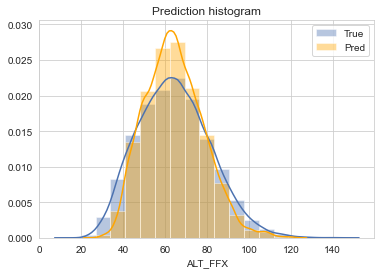

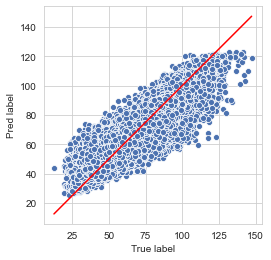

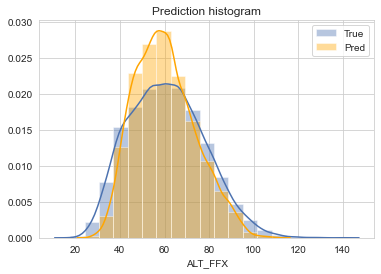

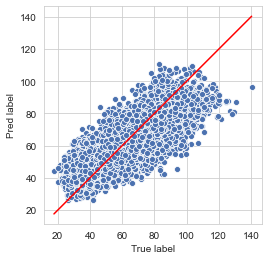

In [58]:
# Evaluate performance of classifier
print("--- Train set ---")
evaluate_regression(y_true=y_train, y_pred=clf.predict(X_train))
print("--- Test set ---")
evaluate_regression(y_true=y_test, y_pred=pred)

Text(0, 0.5, 'Actual FFX values [kt]')

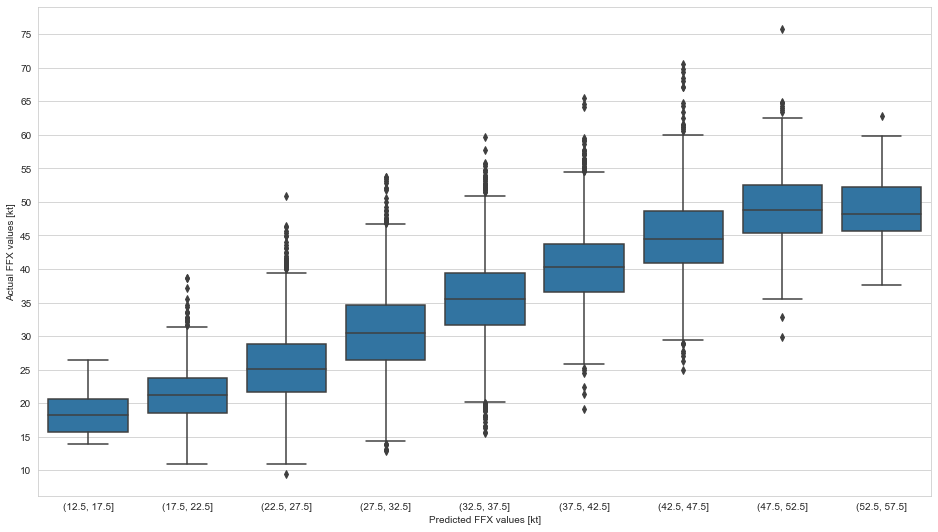

In [59]:
# Create binned plot similar to the one in Gerstgrasser (2017) - only with the prediction of our XGB model
plt.figure(figsize=(16,9))
sns.boxplot(x=pd.cut(pred/1.852, bins=np.arange(12.5,60,5)), y=y_test/1.852, color="tab:blue")
plt.yticks(range(10,80,5))
plt.xlabel(f"Predicted {target_var} values [kt]")
plt.ylabel(f"Actual {target_var} values [kt]")

In [60]:
# Inspect feature importances
df_importances = pd.DataFrame({"features": final_features, "importance": clf.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
df_importances.head(10)

,features,importance
0,diff_ABO_Z850_PIO_Z850,0.099184
1,diff_ENG_Z850_PIO_Z850,0.097870
2,diff_ABO_Z850_MVE_Z850,0.026767
3,diff_MVE_TT_VAD_TT,0.019259
4,diff_PIO_Z850_STG_Z850,0.018531
5,diff_GLA_SLP_SBO_SLP,0.018483
6,diff_SBO_SLP_VAD_SLP,0.015763
7,diff_ABO_Z850_GUE_Z850,0.014212
8,diff_MAG_TT_VAD_TT,0.013229
9,ROB_TT,0.012466


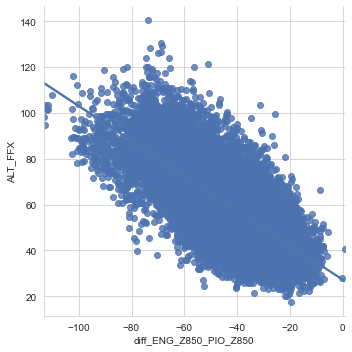

In [61]:
# Inspect single features manually
df_pp = X_test.copy()
df_pp[target] = y_test
var = df_importances.iloc[1, 0]
sns.lmplot(x=var, y=target, data=df_pp) 

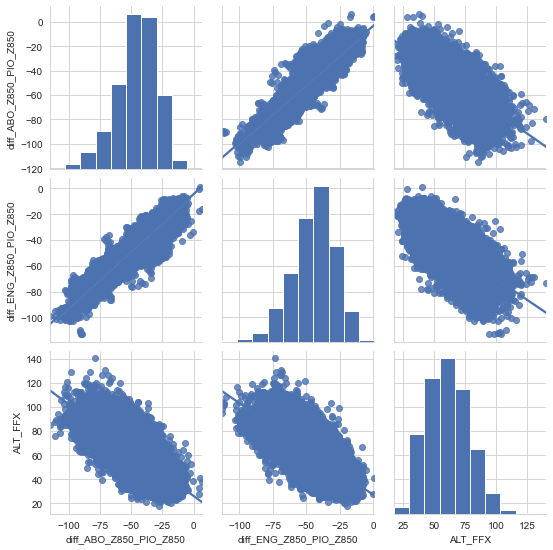

In [62]:
# Inspect pairplot of most important features (quite some outliers in the data which would affect linear regression significantly)
sns.pairplot(df_pp[list(df_importances.iloc[0:2, 0]) + [target]], kind="reg")

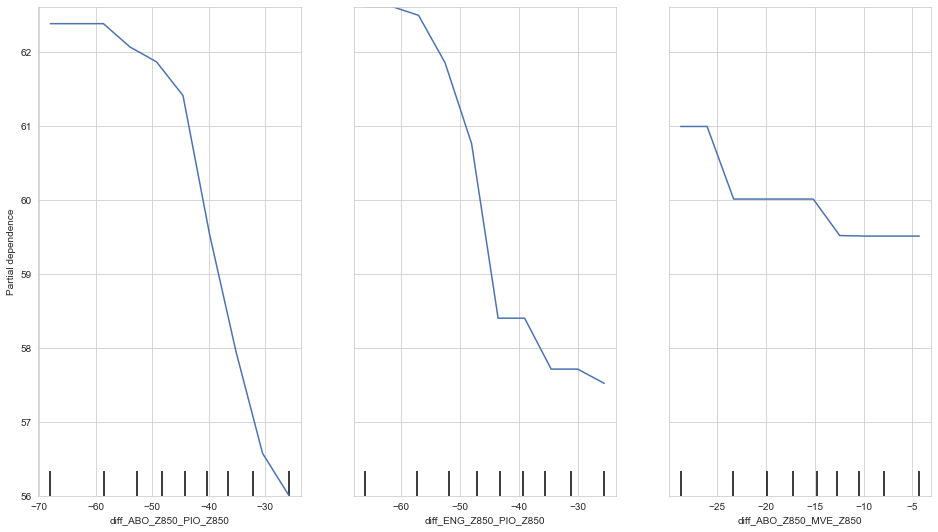

In [42]:
# Inspect partial dependence plots
clf.dummy_ = "dummy" # Due to inconsitency between xgb and sklearn
display = plot_partial_dependence(clf, 
                                  X_test,
                                  percentiles=(0.1,0.9),
                                  features = list(df_importances.loc[0:2, "features"]), 
                                 grid_resolution=10)
display.figure_.subplots_adjust(hspace=0.5)
display.figure_.set_size_inches(16, 9)
#display.figure_.axes[1].set_ylim([0,1])

(CorrCoeff) Correlation Coefficient:  0.7176


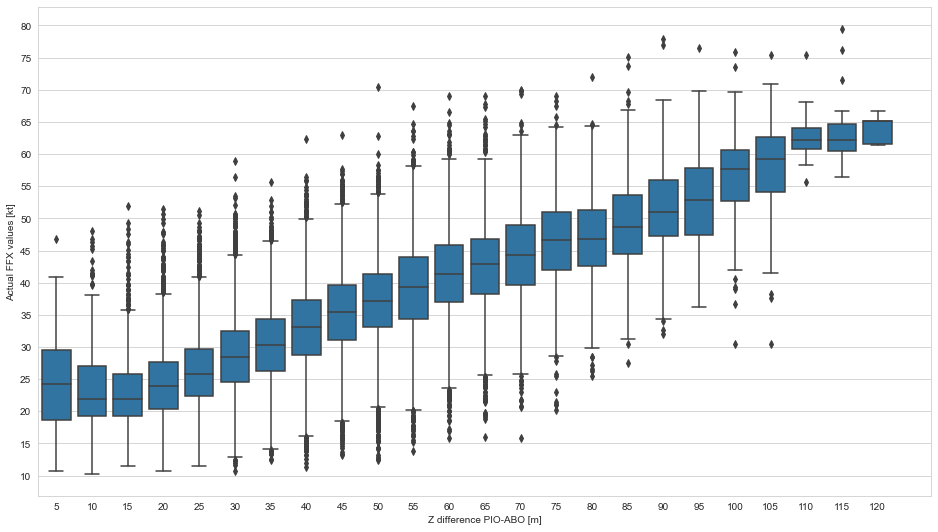

In [63]:
# Create binned plot from Gerstgrasser (2017)
plt.figure(figsize=(16,9))
sns.boxplot(x=pd.cut(-X_train["diff_ABO_Z850_PIO_Z850"], bins=np.arange(2.5,130, 5)), y=y_train/1.852, color="tab:blue")
plt.yticks(range(10,85,5))
plt.gca().set_xticklabels(range(5, 125,5))
plt.xlabel(f"Z difference PIO-ABO [m]")
plt.ylabel(f"Actual {target_var} values [kt]")

# Evaluate correlation
df_pp = X_train.copy()
df_pp[target] = y_train
df_pp.dropna(subset=[target, "diff_ABO_Z850_PIO_Z850"], inplace=True)
print('(CorrCoeff) Correlation Coefficient: ', round(pearsonr(df_pp[target], -df_pp["diff_ABO_Z850_PIO_Z850"])[0], 4)) 